# Import the library


In [ ]:
import pandas as pd
import numpy as np
import keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from PIL import Image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

# Prepare the dataset



*   0 - Glass
*   1 - Paper
*   2 - Cardboard
*   3 - Plastic
*   4 - Metal
*   5 - Trash



In [ ]:
img_path = "/content/drive/MyDrive/datasets/garbages/garbages_no_subfolder/"
img_height = 224
img_width = 224

num_classes = 6

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/datasets/garbages/one-indexed-files-notrash_train.txt', sep=' ', header=None)
test_data = pd.read_csv('/content/drive/MyDrive/datasets/garbages/one-indexed-files-notrash_test.txt', sep=' ', header=None)
val_data = pd.read_csv('/content/drive/MyDrive/datasets/garbages/one-indexed-files-notrash_val.txt', sep=' ', header=None)

X_raw_train = img_path + train_data[0]
y_raw_train = train_data[1]

X_raw_val = img_path + val_data[0]
y_raw_val = val_data[1]

X_raw_test = img_path + test_data[0]
y_raw_test = test_data[1]

In [ ]:
def one_hot_encode(arr, num_classes):
  a = to_categorical(arr, num_classes=num_classes+1)
  a = np.delete(a, 0, 1)
  return a

In [ ]:
y_train = one_hot_encode(y_raw_train, num_classes)
y_val = one_hot_encode(y_raw_val, num_classes)
y_test = one_hot_encode(y_raw_test, num_classes)

In [ ]:
def prepare_images(img_lists):
  arr = np.empty(shape=(len(img_lists), img_width, img_height, 3))
  for i in range(len(img_lists)):
    img = load_img(img_lists[i], target_size=(img_height, img_width))
    img = img_to_array(img)
    img /= 255
    arr[i] = img
  return arr

In [ ]:
X_train = prepare_images(X_raw_train)
X_val = prepare_images(X_raw_val)
X_test = prepare_images(X_raw_test)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1768, 224, 224, 3)
(328, 224, 224, 3)
(431, 224, 224, 3)
(1768, 6)
(328, 6)
(431, 6)


In [ ]:
Xt = X_train.shape[0]
Xval = X_val.shape[0]
Xtest = X_test.shape[0]
total_data = Xt + Xval + Xtest
print(total_data)
Xt_percent = (Xt/total_data) * 100
Xval_percent = (Xval/total_data) * 100
Xtest_percent = (Xtest/total_data) * 100
print(str(Xt_percent) + "%")
print(str(Xval_percent) + "%")
print(str(Xtest_percent) + "%")

2527
69.96438464582508%
12.97981796596755%
17.05579738820736%


# Image augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train, seed=0)

# Membuat identity block

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

# Membuat convolutional block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

# Membuat model ResNet 50

In [ ]:
def ResNet50(input_shape=(img_height, img_height, 3), classes=num_classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (img_height, img_width, 3), classes = num_classes)

In [ ]:
from keras.optimizers import SGD, Adam
adam = Adam(lr = 0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# Membuat callback

In [ ]:
filepath = '/content/drive/MyDrive/Saved Models/garbage_classification_resnet_best_weight_only.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# Loading model

In [ ]:
model.load_weights(filepath)

# Mengevaluasi data

In [ ]:
train_preds = model.evaluate(X_train, y_train)
print ("Loss = " + str(train_preds[0]))
print ("Train Accuracy = " + str(train_preds[1]))

56/56 [==============================] - 278s 5s/step - loss: 0.1010 - accuracy: 0.9696
Loss = 0.10224524140357971
Train Accuracy = 0.9694570302963257


In [ ]:
val_preds = model.evaluate(X_val, y_val)
print ("Loss = " + str(val_preds[0]))
print ("Validation Accuracy = " + str(val_preds[1]))

11/11 [==============================] - 51s 5s/step - loss: 0.6509 - accuracy: 0.8506
Loss = 0.6509175300598145
Validation Accuracy = 0.8506097793579102


In [ ]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

14/14 [==============================] - 67s 5s/step - loss: 0.7165 - accuracy: 0.8237
Loss = 0.7165427803993225
Test Accuracy = 0.8236659169197083


# Confusion matrix

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_plot = y_raw_test - 1

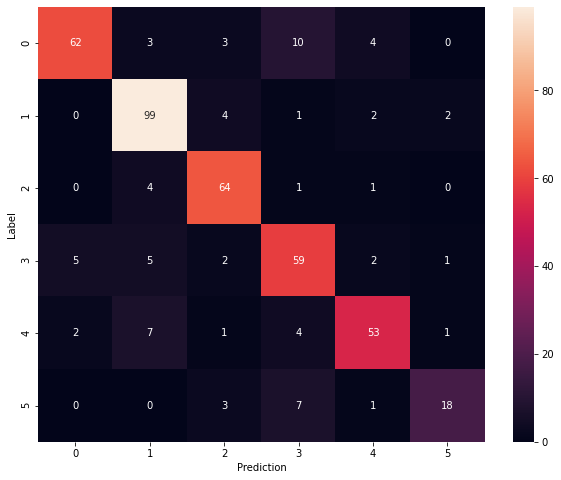

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_plot, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Membuat prediksi



*   0 - Glass
*   1 - Paper
*   2 - Cardboard
*   3 - Plastic
*   4 - Metal
*   5 - Trash



/content/drive/MyDrive/datasets/garbages/garbages_no_subfolder/paper271.jpg


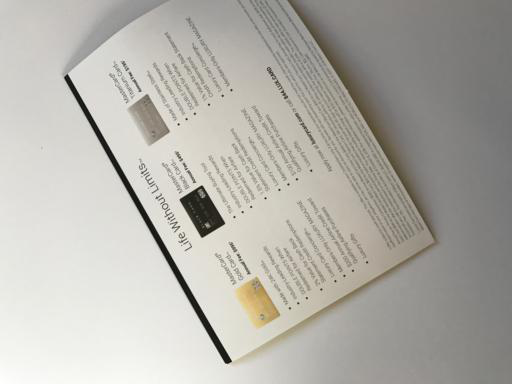

In [ ]:
img_path = X_raw_test[6]
img = load_img(img_path, target_size=(img_height, img_width))
img = img_to_array(img)
img /= 255
img_for_pred = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
print(img_path)
Image.open(img_path)

In [ ]:
img_pred = np.argmax(model.predict(img_for_pred), axis=1)
print(img_pred)

[1]
